In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches as pat
from matplotlib import transforms
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from joblib import load, dump
import re
import scipy.cluster.hierarchy as sch

# custom code
import figutils
import sequence_logo
from quad_model import *
import kl
import force

from collections.abc import Iterable

%matplotlib inline

2022-09-20 21:33:34.847740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-09-20 21:33:34.847760: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def compute_activations_simple_conv(layer,
                                    sequences,
                                    kind='simple'):
    all_seqs_oh = np.array(
        [figutils.nts_to_vector(s_i, rna=True) for s_i in sequences],
        dtype=np.float32)
    
    activations = tf.squeeze(layer(all_seqs_oh), axis=1).numpy()

    dfs_by_filter = dict()
    
    for j in range(activations.shape[1]):
        dfs_by_filter[j] = pd.DataFrame({
        "activation": activations[:, j],
        "input": sequences
    }).sort_values('activation', ascending=False)
    
    return dfs_by_filter

In [4]:
plt.style.use('clean.mplstyle')

# Load model

In [5]:
model_fname = f'../2021_07_31_custom_adjacency_regularization/models/custom_adjacency_regularizer_20210731_124_step3.h5'
model = tf.keras.models.load_model(model_fname)

2022-09-20 21:33:38.994569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-09-20 21:33:38.994592: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-20 21:33:38.994609: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cm003.hpc.nyu.edu): /proc/driver/nvidia/version does not exist
2022-09-20 21:33:38.994805: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# ED Logo for Porg

In [6]:
c_skip_struct = model.get_layer('c_skip_struct')

new_conv = Conv1D(filters=8, kernel_size=30)
new_conv.build(input_shape=(None, 90, 4))
new_conv.kernel.assign(c_skip_struct.kernel.numpy()[:, :4, :])
new_conv.bias.assign(c_skip_struct.bias.numpy())

nts = ['A', 'C', 'G', 'U']
random_nts = np.random.choice(nts, size=(100000, 30))
random_30mers = [''.join(e) for e in random_nts]

struct_conv_acts = compute_activations_simple_conv(new_conv, random_30mers)

In [7]:
df = struct_conv_acts[1]

Iterating over k-mer list:   0%|          | 0/1617 [00:00<?, ?it/s]

findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


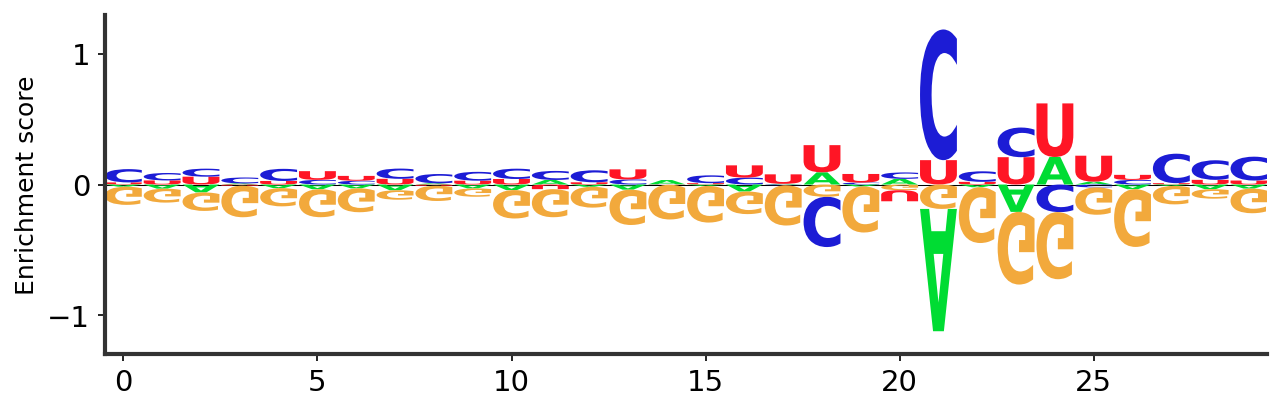

In [8]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
sequence_logo.plot_EDLogo(df, 0, ax)
ax.set_ylim(-1.3, 1.3)
ax.set_ylabel('Enrichment score', fontsize=12)

fig.savefig(
    './figs/porg_edlogo.svg',
    pad_inches=0.1,
    bbox_inches='tight')

Iterating over k-mer list:   0%|          | 0/1617 [00:00<?, ?it/s]

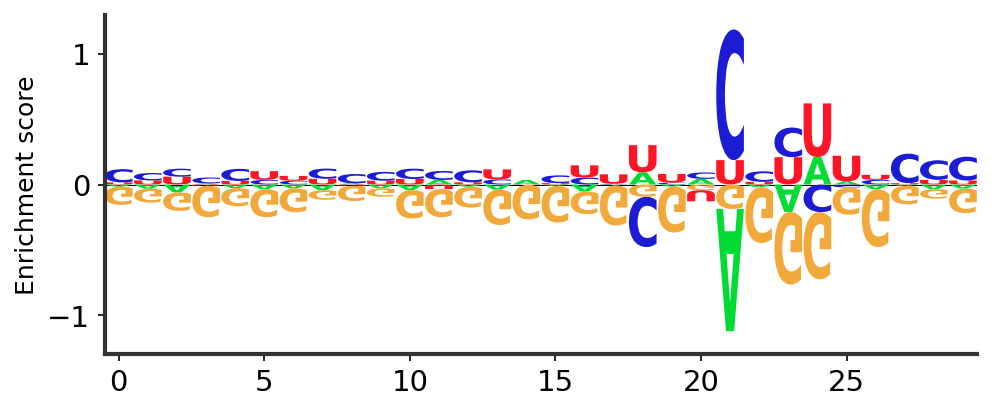

In [9]:
fig, ax = plt.subplots(figsize=(7.5, 3), dpi=150)
sequence_logo.plot_EDLogo(df, 0, ax)
ax.set_ylim(-1.3, 1.3)
ax.set_ylabel('Enrichment score', fontsize=12)

fig.savefig(
    './figs/porg_edlogo_75.svg',
    pad_inches=0.1,
    bbox_inches='tight')

Iterating over k-mer list:   0%|          | 0/1617 [00:00<?, ?it/s]

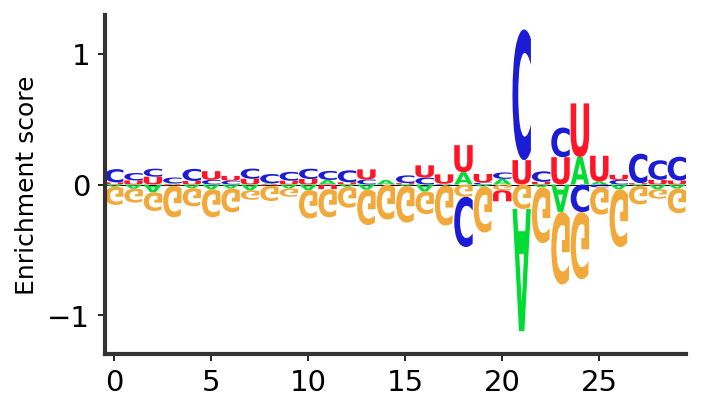

In [10]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
sequence_logo.plot_EDLogo(df, 0, ax)
ax.set_ylim(-1.3, 1.3)
ax.set_ylabel('Enrichment score', fontsize=12)

fig.savefig(
    './figs/porg_edlogo_50.svg',
    pad_inches=0.1,
    bbox_inches='tight')